### Notebook from : https://www.kaggle.com/code/jiaowoguanren/sars-cov-2-ct-scan-dataset-classification-tf-0-99

In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [29]:
!pip install split-folders
import tensorflow as tf
import cv2, pathlib, splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# USE OF SARSCOV2-CTSCAN-DATASET

In [17]:
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

def create_data_binary(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='../sarscov2-ctscan-dataset-splitted/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    train_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/train/', target_size=(img_height, img_width),
                                            class_mode='binary', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/val/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)

    return train_ds, val_ds


train_data, val_data = create_data_binary('../sarscov2-ctscan-dataset/')

Copying files: 2481 files [00:01, 2105.18 files/s]


Found 1736 images belonging to 2 classes.
Found 371 images belonging to 2 classes.


# USE OF COVID-CT-master DATASET

In [30]:
epochs = 30
batch_size = 32
img_height, img_width = 150, 150
input_shape = (img_height, img_width, 3)

data_gen = ImageDataGenerator(rescale=1.0 / 255)

"""
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
"""
                                  
train_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/train/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          subset='training')
                                         
test_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/test/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary')

val_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/val/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          shuffle=False)

Found 425 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [33]:
class BaseModel(tf.keras.Model):
    def __init__(self):
        super(BaseModel, self).__init__()

        self.C1 = Conv2D(32, (3 * 3), padding='same', input_shape = input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(2, padding='same')
        
        self.C2 = Conv2D(32, (3 * 3), padding='same')
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.P2 = MaxPooling2D(2, padding='same')
        self.Dr1 = Dropout(0.3)
        
        self.C3 = Conv2D(32, (3 * 3), padding='same')
        self.B3 = BatchNormalization()
        self.A3 = Activation('relu')
        self.P3 = MaxPooling2D(2, padding='same')
        self.Dr2 = Dropout(0.3)
        
        self.F1 = Flatten()
        self.D1 = Dense(256, activation='relu')
        self.B4 = BatchNormalization()
        self.D2 = Dense(256, activation='relu')
        self.D3 = Dense(256, activation='relu')
        self.D4 = Dense(256, activation='relu')
        self.Dr3 = Dropout(0.3)
        self.D5 = Dense(1, activation='sigmoid')
        
        
    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        
        x = self.C2(x)
        x = self.B2(x)
        x = self.A2(x)
        x = self.P2(x)
        x = self.Dr1(x)
        
        x = self.C3(x)
        x = self.B3(x)
        x = self.A3(x)
        x = self.P3(x)
        x = self.Dr2(x)
        
        x = self.F1(x)
        x = self.D1(x)
        x = self.B4(x)
        x = self.D2(x)
        x = self.D3(x)
        x = self.D4(x)
        x = self.Dr3(x)
        y = self.D5(x)
        
        return y
    
    def __repr__(self):
        name = 'Huang_Model'
        return name
    
    
net = BaseModel()

net.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    net.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True,
                                                 save_best_only=True)

#history = net.fit(train_data, epochs=30, batch_size=batch_size, callbacks=[cp_callback])
history = net.fit(train_data, epochs=30, batch_size=batch_size)

net.summary()

file = open('./weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

Epoch 1/30


2023-03-12 13:45:51.698286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 4s 202ms/step - loss: 0.6485 - accuracy: 0.6282
Epoch 2/30
14/14 [==============================] - 3s 178ms/step - loss: 0.5371 - accuracy: 0.7012
Epoch 3/30
14/14 [==============================] - 3s 177ms/step - loss: 0.4386 - accuracy: 0.7953
Epoch 4/30
14/14 [==============================] - 3s 177ms/step - loss: 0.4249 - accuracy: 0.8141
Epoch 5/30
14/14 [==============================] - 3s 178ms/step - loss: 0.4399 - accuracy: 0.7929
Epoch 6/30
14/14 [==============================] - 3s 177ms/step - loss: 0.3984 - accuracy: 0.8259
Epoch 7/30
14/14 [==============================] - 3s 178ms/step - loss: 0.2837 - accuracy: 0.8753
Epoch 8/30
14/14 [==============================] - 3s 177ms/step - loss: 0.2708 - accuracy: 0.8635
Epoch 9/30
14/14 [==============================] - 3s 173ms/step - loss: 0.2911 - accuracy: 0.8565
Epoch 10/30
14/14 [==============================] - 3s 177ms/step - loss: 0.2574 - accuracy: 0.8918
Epoch 11/3

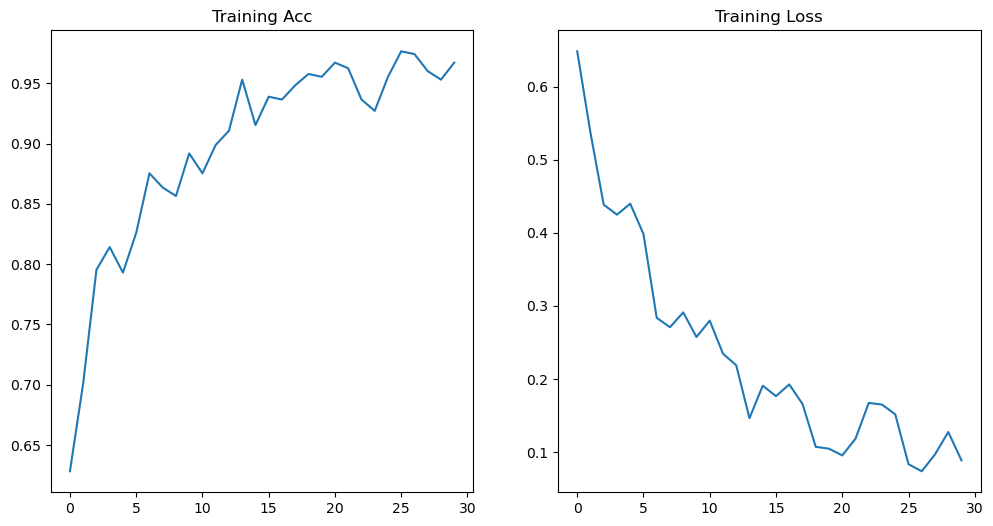

In [34]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()